In [119]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import Input, Dense, Flatten, Lambda, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mse

tf.random.set_seed(1)

In [120]:
(train_img,_),(test_img,_)=tf.keras.datasets.mnist.load_data()

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255
train_img[train_img>=0.5]=1
train_img[train_img<=0.5]=0

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255
test_img[test_img>=0.5]=1
test_img[test_img<=0.5]=0

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=2

train_set=tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_buffer).batch(batch_size)
test_set=tf.data.Dataset.from_tensor_slices(test_img).shuffle(test_buffer).batch(batch_size)

In [121]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D()(x)
    return x

In [122]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [123]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [124]:
inputs=Input(shape=(height,width,3))
input_blend=inputs[:,:,:,:1]

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

input_embed=Input(shape=latent_dimensions)
embed=Dense(np.prod(shape),activation='relu')(input_embed)
embed=Reshape(shape)(embed)

decoded=decoder(embed)
output=Conv2DTranspose(1,3,padding='same')(decoded)

input_embed2=Input(shape=latent_dimensions)
embed2=Dense(np.prod(shape),activation='relu')(input_embed2)
embed2=Reshape(shape)(embed2)

decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [125]:
encode=Model(inputs,z)
encode.summary()

decode1=Model(input_embed,output)
decode1.summary()
decode2=Model(input_embed2,output2)

Model: "functional_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_19 (T [(None, 28, 28, 1)]  0           input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 32)   320         tf_op_layer_strided_slice_19[0][0
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_10[0][0]                  
______________________________________________________________________________________

In [126]:
re1,re2=decode1(encode(inputs)),decode2(encode(inputs))
vae=Model(inputs,re1)
vae.summary()
vae2=Model(inputs,re2)


Model: "functional_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
functional_52 (Functional)   (None, 2)                 31364     
_________________________________________________________________
functional_54 (Functional)   (None, 28, 28, 1)         65089     
Total params: 96,453
Trainable params: 96,453
Non-trainable params: 0
_________________________________________________________________


In [127]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.01,height_shift_range=0.01,
                             shear_range=0.0,zoom_range=[0.8, 1.2])

gen=datagen.flow(train_img, None)

num=6000
comps=2
components=np.array([[gen.next()[0, ..., 0] for j in range(num)] for i in range(comps)])
blended=components.sum(axis=0)
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')

In [128]:
def loss(vae,inputs,re):
    mse_loss=tf.reduce_mean(mse(inputs,re)*height*width)
    vae.add_loss(mse_loss)
    vae.add_metric(mse_loss,'mse_loss')

    kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.01
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss,'kl_loss')

comp0,comp1=components[0],components[1]
comp0=comp0.reshape(comp0.shape[0],height,width,1).astype('float32')
comp1=comp1.reshape(comp1.shape[0],height,width,1).astype('float32')

together=np.concatenate((blended,comp0,comp1),axis=3)

loss(vae,inputs[:,:,:,1:2],re1)
vae.compile(optimizer=Adam())

In [129]:
history=vae.fit(together,verbose=1,epochs=10,batch_size=batch_size)

Epoch 1/10
60/60 [==============================] - 3s 44ms/step - loss: 62.0470 - mse_loss: 62.0123 - kl_loss: 0.0348
Epoch 2/10
60/60 [==============================] - 3s 44ms/step - loss: 53.2735 - mse_loss: 53.1894 - kl_loss: 0.0841
Epoch 3/10
60/60 [==============================] - 3s 44ms/step - loss: 52.5171 - mse_loss: 52.4402 - kl_loss: 0.0770
Epoch 4/10
60/60 [==============================] - 3s 44ms/step - loss: 52.4103 - mse_loss: 52.3401 - kl_loss: 0.0702
Epoch 5/10
60/60 [==============================] - 3s 44ms/step - loss: 52.3220 - mse_loss: 52.2567 - kl_loss: 0.0653
Epoch 6/10
60/60 [==============================] - 3s 44ms/step - loss: 52.1760 - mse_loss: 52.1141 - kl_loss: 0.0619
Epoch 7/10
60/60 [==============================] - 3s 44ms/step - loss: 52.0829 - mse_loss: 52.0271 - kl_loss: 0.0558
Epoch 8/10
60/60 [==============================] - 3s 44ms/step - loss: 52.0683 - mse_loss: 52.0162 - kl_loss: 0.0520
Epoch 9/10
60/60 [==============================

In [130]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,d,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict(z)
    if d==0:
        diff = output_img - input_img
    fig, ax = plt.subplots(3-d, n, figsize=((3)*n,10))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'input {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        if d==0:
            showimg(diff[i], ax[2, i], 'output-input', vmin=-0.5, vmax=0.5)
    return idx

[1483 2185 2520 3721 3727]


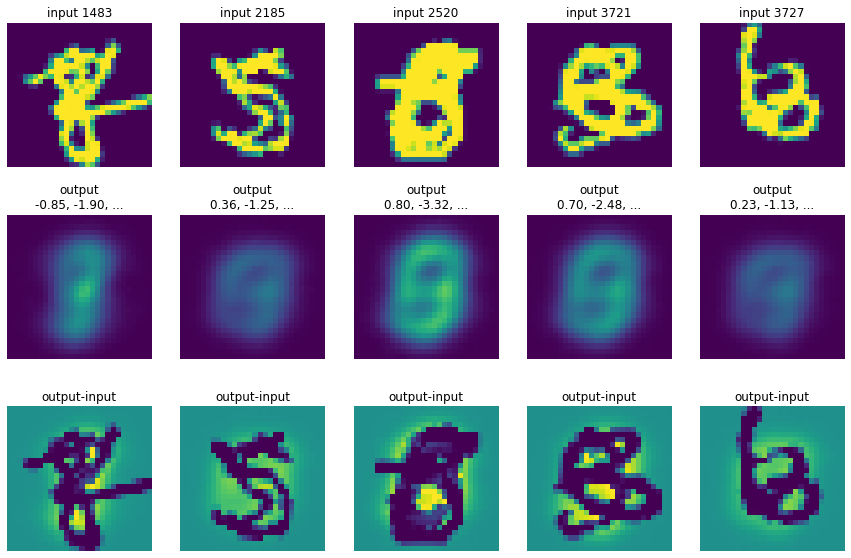

In [131]:
n=5
chosen=summary_plot(n,together[:,:,:,:1],0,decode1)

In [132]:
loss(vae2,inputs[:,:,:,2:3],re2)
vae2.compile(optimizer=Adam())
history=vae2.fit(together,verbose=1,epochs=10,batch_size=batch_size)

Epoch 1/10
60/60 [==============================] - 3s 44ms/step - loss: 58.6793 - mse_loss: 58.5896 - kl_loss: 0.0897
Epoch 2/10
60/60 [==============================] - 3s 44ms/step - loss: 52.6546 - mse_loss: 52.5726 - kl_loss: 0.0820
Epoch 3/10
60/60 [==============================] - 3s 44ms/step - loss: 52.3810 - mse_loss: 52.3025 - kl_loss: 0.0785
Epoch 4/10
60/60 [==============================] - 3s 44ms/step - loss: 52.2249 - mse_loss: 52.1514 - kl_loss: 0.0735 0s - loss: 51.9334 - mse_loss: 51.85
Epoch 5/10
60/60 [==============================] - 3s 44ms/step - loss: 52.1835 - mse_loss: 52.1177 - kl_loss: 0.0658
Epoch 6/10
60/60 [==============================] - 3s 44ms/step - loss: 52.1143 - mse_loss: 52.0533 - kl_loss: 0.0609
Epoch 7/10
60/60 [==============================] - 3s 44ms/step - loss: 52.0621 - mse_loss: 52.0055 - kl_loss: 0.0566
Epoch 8/10
60/60 [==============================] - 3s 45ms/step - loss: 51.9919 - mse_loss: 51.9381 - kl_loss: 0.0538
Epoch 9/10


[1483 2185 2520 3721 3727]


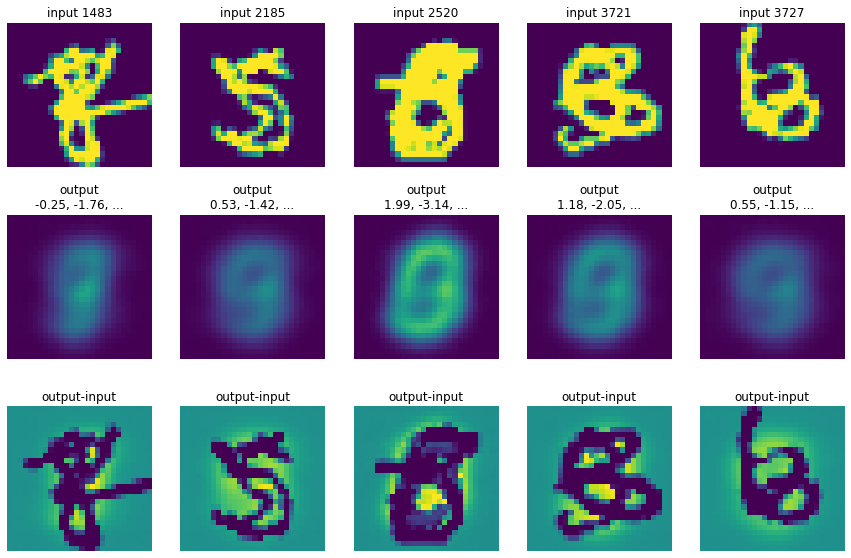

In [133]:
chosen=summary_plot(n,together[:,:,:,:1],0,decode2)

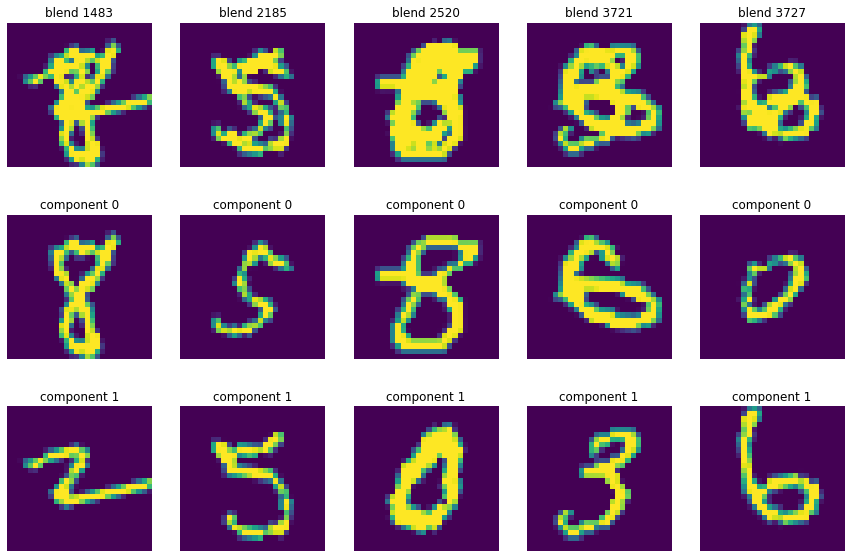

In [134]:
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[chosen[i]],ax[0,i],f'blend {chosen[i]}')
    for j in range(comps):
        showimg(components[j,chosen[i]],ax[j+1,i],f'component {j}')  

In [135]:
summary_plot(n,components[:,0],1)
summary_plot(n,components[:,1],1)

TypeError: summary_plot() missing 1 required positional argument: 'decode'

In [ ]:
summary_plot(n,blended,1)